In [36]:
import locale
# Set to German locale to get comma decimal separater
locale.setlocale(locale.LC_NUMERIC, "de_DE.UTF-8")

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import scienceplots
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from matplotlib.backends.backend_pgf import FigureCanvasPgf
import uncertainties as unc
from uncertainties import unumpy, umath

matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)

plt.rcParams['axes.formatter.use_locale'] = True

# use fancy style and tex in plt
plt.style.use(['science', 'russian-font'])
matplotlib.rc('text', usetex = True)
preamble = plt.rcParams.get('text.latex.preamble')
params = {
  'pgf.rcfonts' : False,
  'pgf.texsystem' : 'pdflatex',
  'pgf.preamble' : "\n".join([preamble,r'\usepackage{textcomp,mathcomp}'])

}
plt.rcParams.update(params)
plt.rcParams.update({"axes.grid" : True, "grid.linestyle" : (0, (5, 10))})

np.random.seed(0)

import os
current_dir = os.getcwd().lower()

OUTPUT_DIR = 'processor_output'
# Create output folder if it does not exist
if (not os.path.exists(f'./{OUTPUT_DIR}')):
    os.makedirs(OUTPUT_DIR)

In [14]:
parmalloy = pd.read_csv('parmalloy.csv')
parmalloy.x = unumpy.uarray(parmalloy.x, 0.2)
parmalloy.y = unumpy.uarray(parmalloy.y, 0.2)
parmalloy

,x,y
0,4.20+/-0.20,4.00+/-0.20
1,3.70+/-0.20,3.60+/-0.20
2,3.00+/-0.20,3.00+/-0.20
3,2.80+/-0.20,2.50+/-0.20
4,2.70+/-0.20,2.30+/-0.20
5,2.60+/-0.20,1.80+/-0.20
6,2.40+/-0.20,1.30+/-0.20
7,2.20+/-0.20,1.00+/-0.20
8,2.00+/-0.20,0.60+/-0.20
9,1.70+/-0.20,0.30+/-0.20


In [26]:
ferrit = pd.read_csv('ferrit.csv')
ferrit.x = unumpy.uarray(ferrit.x, 0.2)
ferrit.y = unumpy.uarray(ferrit.y, 0.2)

fesi = pd.read_csv('fesi.csv')
fesi.x = unumpy.uarray(fesi.x, 0.2)
fesi.y = unumpy.uarray(fesi.y, 0.2)

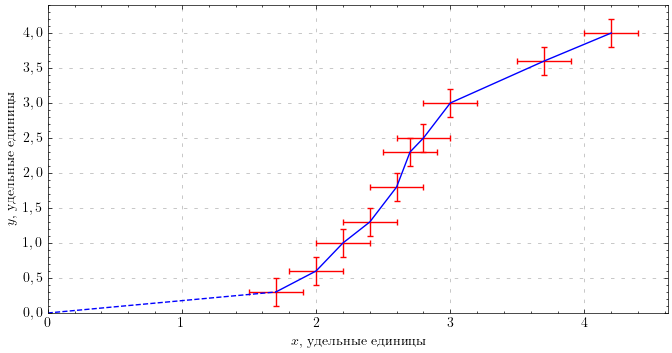

In [25]:
def plot_x_y(ax, df):
  x_raw = df.x
  y_raw = df.y
  x = unumpy.nominal_values(x_raw)
  y = unumpy.nominal_values(y_raw)
  xerr = unumpy.std_devs(x_raw)
  yerr = unumpy.std_devs(y_raw)

  # ax.scatter(x, y, s=10, zorder=10, c='red')
  ax.errorbar(x, y, yerr=yerr, xerr=xerr,  ecolor='red',
              capsize=2, c='b')
  ax.plot([0, x.min()], [0, y.min()], c='b', linestyle='--')

  ax.set_xlabel(r'$x$, удельные единицы')
  ax.set_ylabel(r'$y$, удельные единицы')
  # ax.set_title(title)
  ax.set_xlim(0, x.max()*1.1)
  ax.set_ylim(0, y.max()*1.1)

fig, ax = plt.subplots(figsize=(8, 4))
plot_x_y(ax, parmalloy)
# ax.set_title('Параметры петли гистерезиса для образца из пермаллоя')
plt.savefig(f'{OUTPUT_DIR}/parmalloy_x_y.pgf')

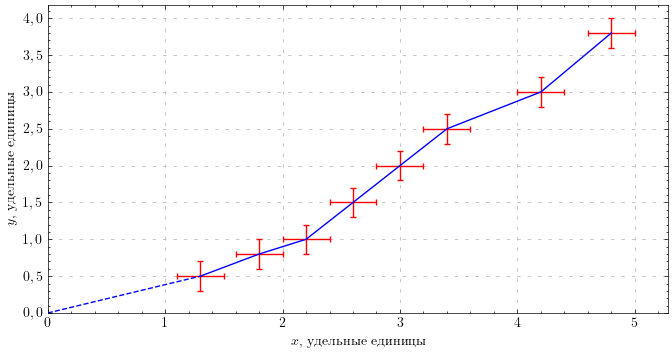

In [27]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_x_y(ax, ferrit)
plt.savefig(f'{OUTPUT_DIR}/ferrit_x_y.pgf')

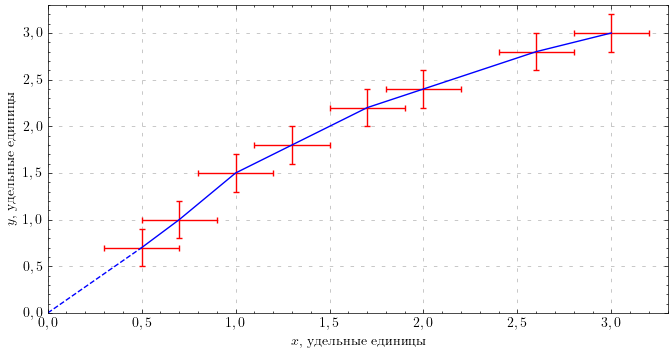

In [28]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_x_y(ax, fesi)
plt.savefig(f'{OUTPUT_DIR}/fesi_x_y.pgf')

In [65]:
df = pd.read_csv('char.csv', index_col=0)
df.kx = df.kx / 1000
df.ky = df.ky / 1000
df['2xc'] = unumpy.uarray(df['2xc'], 0.2)
df['2yr'] = unumpy.uarray(df['2yr'], 0.2)
df['width'] = unumpy.uarray(df['width'], 0.2)
df['height'] = unumpy.uarray(df['height'], 0.2)
df['Hc'] = unumpy.uarray([56, 43, 120], [2, 3, 15])
df['Bs'] = unumpy.uarray([1.8, 0.59, 1.26], [0.2, 0.08, 0.15])
df

,width,height,2xc,2yr,kx,ky,Hc,Bs
parmalloy,8.50+/-0.20,8.00+/-0.20,5.80+/-0.20,7.40+/-0.20,0.02,0.05,56.0+/-2.0,1.80+/-0.20
ferrit,9.50+/-0.20,7.50+/-0.20,4.00+/-0.20,3.60+/-0.20,0.05,0.05,43.0+/-3.0,0.59+/-0.08
fesi,6.00+/-0.20,5.80+/-0.20,1.80+/-0.20,3.00+/-0.20,0.05,0.05,120+/-15,1.26+/-0.15


In [63]:
def generate_latex_table(data, column_names, rounding_precisions, index_names=None, include_numbering=False, save_to_file=None):
  # Create the LaTeX table header
  table_header = "\\begin{tabular}{"
  if include_numbering:
    table_header += "c"
  for _ in range(len(column_names)):
    table_header += "c"
  table_header += "}\n"
  table_header += "\\toprule\n"

  # Create the column headers
  if include_numbering:
    table_header += " & "
  for i, name in enumerate(column_names):
    table_header += f"{name} & "
  table_header = table_header[:-2] + "\\\\\n"
  table_header += "\\midrule\n"

  # Create the table rows
  table_rows = ""
  for i, row in enumerate(zip(*data)):
    if include_numbering:
      table_rows += f"{i+1} & "
    if index_names:
      table_rows += f"{index_names[i]} & "
    for j, value in enumerate(row):
      if isinstance(value, int) or isinstance(value, float):
        if rounding_precisions[j] == 0:
          table_rows += f"{value:.0f} & "
        else:
          table_rows += f"${value:.{rounding_precisions[j]}f}$ & "
        continue
      if not umath.isnan(value):
        if rounding_precisions[j] == 0:
          table_rows += rf"{value.nominal_value:.0f} & "
        else:
          table_rows += rf"${value:.{rounding_precisions[j]}uL}$ & "
      else:
        table_rows += " & "
    table_rows = table_rows[:-2] + "\\\\\n"

  # Create the table footer
  table_footer = "\\bottomrule\n"
  table_footer += "\\end{tabular}"

  # Combine the table components
  table_rows = table_rows.replace('.', ',')
  latex_table = table_header + table_rows + table_footer

  # Save to file if specified
  if save_to_file:
    with open(save_to_file, 'w') as f:
      f.write(latex_table)

  return latex_table

In [70]:
import uncertainties as unc
import uncertainties
from uncertainties import unumpy

data = [df[col] for col in df.columns]
column_names = ['$w$, уд.ед.', '$h$, уд.ед.', '$2X_c$, уд.ед.', '$2Y_r$, уд.ед.', '$k_x$, В', '$k_y$, В', '$H_c$, А/м', '$B_s$, Тл']
index_names = ['Пермаллой', 'Феррит', 'Кремнистое железо']
rounding_precisions = [1, 1, 1, 1, 2, 2, 2, 2]

generate_latex_table(data, column_names, rounding_precisions, include_numbering=True, save_to_file=f'{OUTPUT_DIR}/tbl_char.tex');